Function to load data to the variable data_frame

In [ ]:
#@title Import data file from Google Drive
from google.colab import drive

drive.mount('/content/drive')

file_directory = "/content/drive/MyDrive/BlockingNotebook/data-01000-00500-abcd.csv" #@param {type:"string"}

Mount the google drive and change the fiel directory to match with your layout

In [ ]:
#@title Upload file from local computer
from google.colab import files
import os

files.upload()

for file in os.listdir("/content"):
    if file.endswith(".csv"):
        file_directory = "/content/" + str(file)

Manually upload a data file (.csv) to your /content directory.

If multiple csv files exist, the first one will be selected

In [ ]:
#@title Load function
import csv

def load_data(file_directory):

    data_frame = []

    with open(file_directory) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
#        next(csv_reader)
        for row in csv_reader:
            data_frame.append(row)

    return data_frame

In [ ]:
#@title Load data to data_frame variable
data_frame = load_data(file_directory)

Load csv file generated by the data generator function
Need to mount drive to access these files, can change it in the future to run data generator and blocking notebook together in the future

In [ ]:
#@title Load blocking algorithms from Github repo
!git clone https://github.com/jembi/mpi-toolkit-notebook.git

Load .py files for the various blocking algorithms to import and implement

In [ ]:
#@title Change working directory to import py modules
import sys
import os

py_file_location = "/content/mpi-toolkit-notebook/blocking-notebook" #@param {type:"raw"}
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
#@title Import blocking libraries and algorithms
!pip install phonetics
!pip install fastDamerauLevenshtein
!pip install textdistance

import compare_soundex
import compare_metaphone
import compare_double_metaphone
import compare_levenshtein
import compare_damerau_levenshtein
import compare_jaro_winkler
import compare_jaccard_similarity
import compare_exact_match

In [99]:
#@title Widgets to interact and choosing blocking methods

from ipywidgets import HBox, VBox, Checkbox, Dropdown, Button, FloatSlider
from IPython.display import display

list_limit = 6 #@param {type:"integer"}
criteria_list = [[] for _ in range(list_limit)]
criteria_list_index = 0 

columns = ["None"] + data_frame[0][1:]
columns_field = Dropdown(description="Columns: ", options=[c for c in columns])
algorithm_field = Dropdown(description="Algorithms: ", options=["None", "Exact Match", "Jaro-Winkler Similarity", "Levenshtein Edit Distance", "Damerau-Levenshtein Edit Distance", "Jaccard Similarity", "SoundEx", "Metaphone", "Double Metaphone"], disabled=True)
level_slider = FloatSlider(description="Level: ", value=0, min=0, max=5, step=1, disabled=True)

def change_algorithm(*args):
    algorithm_field.disabled=False
    union_button.disabled=True
columns_field.observe(change_algorithm, 'value')

def change_slide(*args):
    if algorithm_field.value in ["Levenshtein Edit Distance", "Damerau-Levenshtein Edit Distance"]:
        level_slider.disabled=False
        level_slider.value=2
        level_slider.max=5
        level_slider.step=1
    elif algorithm_field.value in ["Jaro-Winkler Similarity", "Jaccard Similarity"]:
        level_slider.value=0.85
        level_slider.max = 1
        level_slider.step=0.05
        level_slider.disabled=False
algorithm_field.observe(change_slide, 'value')

intersection_button = Button(description="Intersection")        # "Add"
union_button = Button(description="Union", disabled=True)       # "Update"
reset_button = Button(description="Reset")

def print_union():
    
    for item in criteria_list:
        if item:
            print(item)

def print_intersection():
    print("Column:    {}\nAlgorithm: {}\nLevel:     {}".format(columns_field.value, algorithm_field.value, level_slider.value))



def intersection_click(*args):
    print_intersection()                          # prints what you just selected
    criteria_list[criteria_list_index].append([columns_field.value, algorithm_field.value, level_slider.value])

    # reset the columns, algorithm and level field
    columns_field.value="None"
    algorithm_field.value="None"
    algorithm_field.disabled=True
    level_slider.disabled=True
    level_slider.value=0

    union_button.disabled=False         # activate the union button so dict can be added to the criteria_union_list
    

def union_click(*args):
    global criteria_list_index
    if criteria_list_index < 6:
        criteria_list_index += 1
    else:
        print("Criteria list full, update criteria list limit")

    # reset the columns, algorithm. Deactivate the algorithm and level dropdowns, and union button again
    columns_field.value="None"
    algorithm_field.value="None"
    algorithm_field.disabled=True
    level_slider.disabled=True
    union_button.disabled=True
    level_slider.value=0

    print_union()

def reset_click(*args):
    # reset everything
    criteria_list = [[] for _ in range(list_limit)]

    columns_field.value="None"
    algorithm_field.value="None"
    algorithm_field.disabled=True
    level_slider.disabled=True
    union_button.disabled=True
    level_slider.value=0
    print("Criteria reset")

intersection_button.on_click(intersection_click)
union_button.on_click(union_click)
reset_button.on_click(reset_click)


dropdown_list = HBox([columns_field, algorithm_field, level_slider])
button_list = HBox([intersection_button, union_button, reset_button])
VBox([dropdown_list, button_list])

1. Choose which column you want to block on.
2. That enables you to choose which algorithm approach
3. Depending on the algorithm (similairty, edit distance, phonetic match), this can allow for the level to be selected.
4. To click on intersection adds it to the list. Any items added by intersection follow an 'and' rule where all must be true to return true.
5. After selecting intersection, 'Union' is enabled to add an 'or' option between criteria.
6. If an error occurs, click reset to empty the criteria_list.
7. A maximum of 6 criteria within the union list can be added, there is no limit to the number of intersections that are required. This limit can be extended but it is not recommended.
8. Do not forget to press 'Intersection' to add your selection to criteria_list.

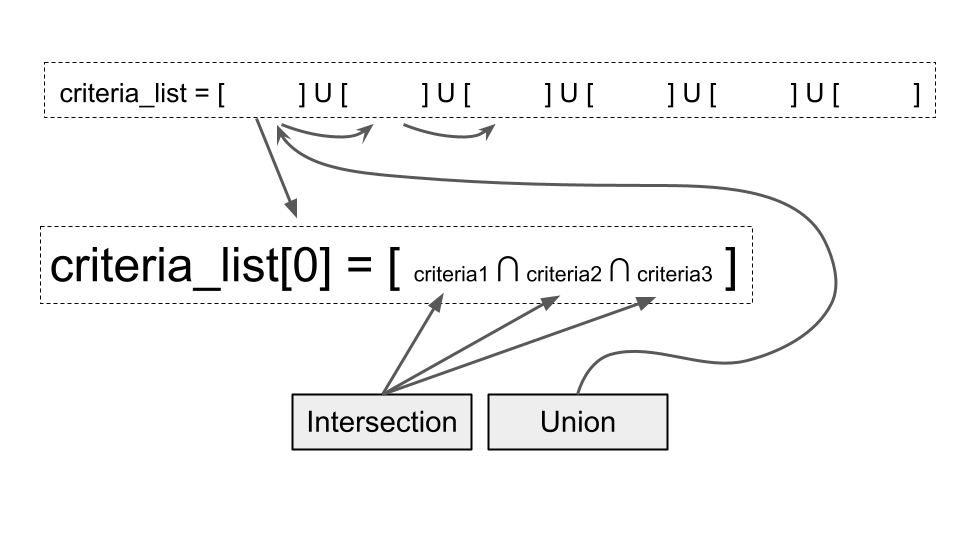



In [ ]:
#@title Summarise data

criteria_list = criteria_list[:criteria_list_index]

for c in criteria_list:
    if c:
        print(c)

Summarise the criteria list

Options in the same line are being tested for the intersection (&&) e.g. record names macth and record father's names match to be true
Options on different lines work in union (||)

Basic table output for user to choose which columns they would like to block on using which algorithms

Level of each blocking (edit ditance and similarity) to be included at a later stage.

Extract the columns the user would like to test using the algorithms they have selected

In [ ]:
#@title Blocking function

def blocking(rec1, rec2, criteria_list):

    for criteria in criteria_list:
        if criteria:
            intersection_count = 0
            for option in criteria:
                result = implement(rec1[column_identity(option[0])], rec2[column_identity(option[0])], option[1], option[2])
                if result:
                    intersection_count += 1
            if intersection_count == len(criteria):
                return True
    return False


Criteria_list has a list of union options that any can be fulfilled to block on

Within each option are intersection options that all must be fulfilled to return true - so if intersection_count is the same as the length of criteria, then it will return true

If any of these fail to return true, blocking return false on the records

In [ ]:
#@title Implementation function

def implement(field1, field2, algorithm, level):

    if algorithm == "Exact Match":
        return compare_exact_match.compare(field1, field2)
    elif algorithm == "Jaro-Winkler Similarity":
        return compare_jaro_winkler.compare(field1, field2, level)
    elif algorithm == "Levenshtein Edit Distance":
        return compare_levenshtein.compare(field1, field2, level)
    elif algorithm == "Damerau-Levenshtein Edit Distance":
        return compare_damerau_levenshtein.compare(field1, field2, level)
    elif algorithm == "Jaccard Similarity":
        return compare_jaccard_similarity.compare(field1, field2, level)
    elif algorithm == "SoundEx":
        return compare_soundex.compare(field1, field2)
    elif algorithm == "Metaphone":
        return compare_metaphone.compare(field1, field2)
    elif algorithm == "Double Metaphone":
        return compare_double_metaphone.compare(field1, field2)
    else:
        return None

Depending on what algorithm was chosen, will execute the .py files that were cloned from the GutHub repo with the level selected.

Level can also be left out as the default values: edit distance = 2, similarity = 0.85

In [ ]:
#@title Missing data function

def missing_data(rec1, rec2, criteria_list):

    for criteria in criteria_list:
        if criteria:
            for option in criteria:
                if not rec1[column_identity(option[0])] or not rec2[column_identity(option[0])]:
                    return True
    return False

If failed to block using the algorithms, this checks if there was missing information and includes it if true. 

Cannot block against missing information.

Would be faster if missing data were run first but this step is meant to see how well the blocking algorithms perform first before missing data inclusions is included

In [ ]:
#@title Name index function

def column_identity(name):

    for ind, col_name in enumerate(columns):
        if col_name == name:
            return ind + 1

Returns the data_frame column index of variable name given

In [ ]:
#@title Result summaries

from IPython.display import HTML, display
import tabulate


def print_summary(runtime):

    print("Blocking on the data from file {} with {} records using the following columns and algorithms:".format(file_name, len(data_frame)-1))
    for criteria in criteria_list:
        print("{}".format(criteria))
    print("This method identified {} True Positive matches with a further {} positive matches in the missing data inclusion.".format(true_pos, missing_pos))
    print("{} False Negative matches and {} False Positive matches produce a recall rate of {} and precision of {}".format(false_neg, false_pos, (true_pos + missing_pos) / (true_pos + missing_pos + false_neg), (true_pos + missing_pos) / (true_pos + missing_pos + false_pos)))
    print("{} matches were excluded out of the {} total matches, providing a blocking efficiency of {}".format(false_neg + true_neg, total_matches, (false_neg + true_neg) / total_matches))
    print("Runtime = {}".format(runtime))


def print_summary_table(runtime):
    data = [["Total matches", total_matches],
            ["Matches excluded", false_neg + true_neg],
            ["Missing data inclusions", total_missing],
            ["Missing data positives", missing_pos],
            ["Algorithm positives", true_pos],
            ["Total true positives", true_pos + missing_pos],   
            ["False negatives", false_neg],
            ["False positives", false_pos],
            ["Recall", (true_pos + missing_pos) / (true_pos + missing_pos + false_neg)],
            ["Precision", (true_pos + missing_pos) / (true_pos + missing_pos + false_pos)],
            ["Blocking efficiency", (true_neg + false_neg) / total_matches],
            ["Runtime", runtime]]
    display(HTML(tabulate.tabulate(data, tablefmt='html')))


Summary in paragraph form

Summary in table form

In [ ]:
#@title Execute blocking on data_frame

from time import time
from tqdm.notebook import tqdm


start_time = time()

true_pos, false_neg, false_pos, true_neg = 0, 0, 0, 0
total_matches = 0
total_missing, missing_pos= 0, 0

for i in tqdm(range(1, len(data_frame))):
    for j in range(i+1, len(data_frame)):
        total_matches += 1
        match_bool = blocking(data_frame[i], data_frame[j], criteria_list)
        if match_bool:
            if data_frame[i][0][:12] == data_frame[j][0][:12]:
                true_pos += 1
            else:
                false_pos += 1
        elif missing_data(data_frame[i], data_frame[j], criteria_list):
            total_missing += 1
            if data_frame[i][0][:12] == data_frame[j][0][:12]:
                missing_pos += 1
            else:
                false_pos += 1
        else:
            if data_frame[i][0][:12] == data_frame[j][0][:12]:
                false_neg += 1
            else:
                true_neg += 1

end_time = time()

Iterates through all combinations of records once, skipping repeated and unnecessary comparisons.

tqdm provides a progress bar for the user to see how long it will take

Each record pair is compared in the blocking function

Keeps track of:
true positives
false positives
true negatives
false negatives
missing data positives
missing data inclusions
total matches
runtime

In [ ]:
#@title Display results in paragraph format
print_summary(end_time - start_time)

In [ ]:
#@title Display results in table
print_summary_table(end_time - start_time)

In [ ]:
#@title Display results in pie charts using matplotlib
import matplotlib.pyplot as plt

recall = (true_pos + missing_pos) / (true_pos + missing_pos + false_neg)
recall_labels = ["Recall", " "]
recall_sections = [recall, 1 - recall]


precision = true_pos / (true_pos + false_pos + missing_pos)
prec_labels = ["Precision", " "]
prec_sections = [precision, 1 - precision]

blocking_efficiency = (true_neg + false_neg) / total_matches 
be_labels = ["Blocking efficiency", " "]
be_sections = [blocking_efficiency, 1 - blocking_efficiency]

positives = [true_pos]
pos_labels = ["True positives"]
if missing_pos:
    positives.append(missing_pos)
    pos_labels.append("Missing data positives")
if false_neg:
    positives.append(false_neg)
    pos_labels.append("False positives")

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
colors = ["#6396e6", "#de73e6"]


axes[0].pie(recall_sections, 
        labels=recall_labels, 
        colors=colors, 
        startangle=90,
        autopct='%1.4f%%')
axes[1].pie(prec_sections, 
        labels=prec_labels, 
        colors=colors,
        startangle=90, 
        autopct='%1.4f%%')
axes[2].pie(be_sections, 
        labels=be_labels, 
        colors=colors, 
        startangle=90, 
        autopct='%1.4f%%')
axes[3].pie(positives, 
            labels=pos_labels, 
            colors=["#6396e6","#63e581", "#de73e6"], 
            startangle=90,
            autopct='%1.4f%%')

plt.title("Pie charts showing Recall, Precision and Blocking Efficiency")